In [6]:
!pip install mediapipe opencv-python scikit-learn imbalanced-learn pandas

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

2024-06-24 00:06:51.548437: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 00:06:51.747773: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 00:06:52.532117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 00:06:53.987594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
## Testando caminho

(-0.5, 47.5, 47.5, -0.5)

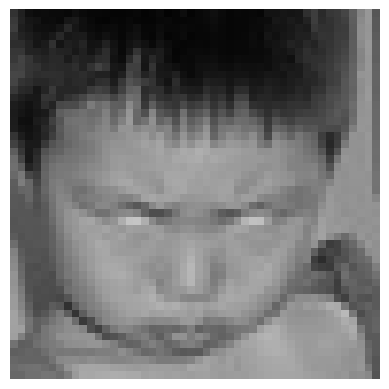

In [21]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

In [5]:
image = cv2.imread('Documents/projetos/FER-2013_emotion_detection/archive/test/angry/PrivateTest_10131363.jpg', 0)
plt.imshow(image)

[ WARN:0@63.309] global loadsave.cpp:241 findDecoder imread_('Documents/projetos/FER-2013_emotion_detection/archive/test/angry/PrivateTest_10131363.jpg'): can't open/read file: check file path/integrity


NameError: name 'plt' is not defined

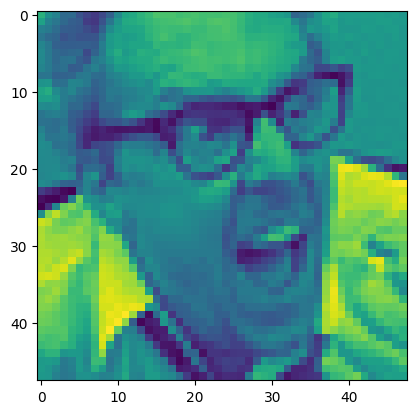

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

In [7]:
## Antes de remover as imagens

In [18]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test
There are 0 directories and 831 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/surprise
There are 0 directories and 1024 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/fear
There are 0 directories and 111 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/disgust
There are 0 directories and 1233 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/neutral
There are 0 directories and 1774 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/happy
There are 0 directories and 1247 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/sad
There are 0 directories and 9

In [ ]:
## Depois de remover as imagens

In [23]:
for dirpath,dirname,filenames in os.walk('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'):
    print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive
There are 7 directories and 0 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test
There are 0 directories and 790 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/surprise
There are 0 directories and 961 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/fear
There are 0 directories and 98 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/disgust
There are 0 directories and 1201 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/neutral
There are 0 directories and 1728 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/happy
There are 0 directories and 1137 images in /home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/sad
There are 0 directories and 875

In [46]:
## Iniciando

In [31]:
# Definição dos pontos da face
list_points = list(mp.solutions.face_mesh.FACEMESH_LIPS)
list_points.extend(mp.solutions.face_mesh.FACEMESH_LEFT_EYE)
list_points.extend(mp.solutions.face_mesh.FACEMESH_LEFT_IRIS)
list_points.extend(mp.solutions.face_mesh.FACEMESH_LEFT_EYEBROW)
list_points.extend(mp.solutions.face_mesh.FACEMESH_RIGHT_EYE)
list_points.extend(mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS)
list_points.extend(mp.solutions.face_mesh.FACEMESH_RIGHT_EYEBROW)
list_points.extend([21, 54, 103, 67, 109, 10, 338, 297, 332, 284, 251])
list_points.extend([71, 68, 104, 69, 108, 151, 337, 299, 333, 298, 301, 9])
list_points.extend([143, 111, 117, 118, 119, 120, 121, 128, 245])
list_points.extend([214, 207, 205, 36, 142, 126, 217, 174])
list_points.extend([372, 340, 346, 347, 348, 349, 350, 357, 465])
list_points.extend([434, 427, 425, 266, 371, 355, 437, 399])

# Converter para uma lista de pontos únicos
points_face = set()
for point in list_points:
    if isinstance(point, int):
        points_face.add(point)
    else:
        points_face.add(point[0])
        points_face.add(point[1])

points_face = list(points_face)
print(points_face)
print("Total de pontos:", len(points_face))

[0, 7, 9, 10, 13, 14, 17, 21, 33, 36, 37, 39, 40, 46, 52, 53, 54, 55, 61, 63, 65, 66, 67, 68, 69, 70, 71, 78, 80, 81, 82, 84, 87, 88, 91, 95, 103, 104, 105, 107, 108, 109, 111, 117, 118, 119, 120, 121, 126, 128, 133, 142, 143, 144, 145, 146, 151, 153, 154, 155, 157, 158, 159, 160, 161, 163, 173, 174, 178, 181, 185, 191, 205, 207, 214, 217, 245, 246, 249, 251, 263, 266, 267, 269, 270, 276, 282, 283, 284, 285, 291, 293, 295, 296, 297, 298, 299, 300, 301, 308, 310, 311, 312, 314, 317, 318, 321, 324, 332, 333, 334, 336, 337, 338, 340, 346, 347, 348, 349, 350, 355, 357, 362, 371, 372, 373, 374, 375, 380, 381, 382, 384, 385, 386, 387, 388, 390, 398, 399, 402, 405, 409, 415, 425, 427, 434, 437, 465, 466, 469, 470, 471, 472, 474, 475, 476, 477]
Total de pontos: 157


In [32]:
# Caminho para o diretório de treinamento das imagens
IMG_FOLDER_TRAIN = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/'

# Lista para armazenar caminhos e emoções das imagens
list_imgs = []

# Iterar sobre todas as classes no diretório de treinamento
trainpath = os.listdir(IMG_FOLDER_TRAIN)
for cls in trainpath:
    print(f"Lendo diretório: {cls}")
    for img in os.listdir(IMG_FOLDER_TRAIN + cls):
        list_imgs.append([cls + "/" + img, cls])

# Criar um DataFrame com os caminhos dos arquivos e as emoções
df = pd.DataFrame(list_imgs, columns=['Filepath', 'emotion'])
df.head()

# Verificar classes únicas e contagens
unique_classes, class_counts = df['emotion'].value_counts().index, df['emotion'].value_counts().values
print("Classes únicas:", unique_classes)
print("Contagem de amostras por classe:", class_counts)

Lendo diretório: surprise
Lendo diretório: fear
Lendo diretório: disgust
Lendo diretório: neutral
Lendo diretório: happy
Lendo diretório: sad
Lendo diretório: angry
Classes únicas: Index(['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise', 'disgust'], dtype='object', name='emotion')
Contagem de amostras por classe: [7005 4852 4444 3763 3654 3043  385]


In [33]:
## Remover imagens que não são rostos

In [34]:
face_detector = mp.solutions.face_detection.FaceDetection()
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection'

for dataset in ['train', 'test']:
    dataset_dir = os.path.join(data_dir, 'archive', dataset)
    for emotion_dir in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion_dir)
        if os.path.isdir(emotion_path):
            image_paths = [os.path.join(emotion_path, f) for f in os.listdir(emotion_path)]
            for image_path in image_paths:
                image = cv2.imread(image_path)
                results = face_detector.process(image)
                if not results.detections:
                    os.remove(image_path)
                    print(f"Removida imagem incorreta: {image_path}")

I0000 00:00:1719194723.868474   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719194723.882620   95763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719194723.884447   95758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/jupyter-env/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [35]:
# Função para extrair landmarks usando Mediapipe
def extract_landmarks(image):
    # Converter imagem de escala de cinza para RGB se necessário
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image
    
    # Inicializar o modelo de Mediapipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh.FaceMesh()

    # Processar a imagem para obter os resultados dos landmarks
    results = mp_face_mesh.process(image_rgb)
    
    # Verificar se foram detectados landmarks
    if results.multi_face_landmarks:
        landmarks = np.array([[landmark.x, landmark.y] for landmark in results.multi_face_landmarks[0].landmark])
        return landmarks.reshape(-1)
    else:
        return None

In [ ]:
# Função para carregar imagens e extrair landmarks em lotes
def process_images_in_batches(images):
    landmarks_list = []
    for image in images:
        landmarks = extract_landmarks(image)
        if landmarks is not None:
            landmarks_list.append(landmarks)
    return np.array(landmarks_list)

X_train_landmarks = process_images_in_batches(X_train_images)
print(f"Tamanho de X_train_landmarks: {len(X_train_landmarks)}")

# Verifique se o tamanho de X_train_landmarks é igual ao tamanho de X_train_sample e y_train_sample
assert len(X_train_landmarks) == len(X_train_sample) == len(y_train_sample), "Tamanhos inconsistentes entre dados de treinamento e landmarks"

I0000 00:00:1719195530.954011   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719195530.969438  106463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719195530.971882  106456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719195530.979049  106458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1719195530.992726   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719195531.026214  106472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719195531.027859  106466 inference_feedback_manager.cc:114] Feedback manager requires a model wit

In [49]:
# Amostra de dados para treinamento e teste (ajuste conforme necessário)
sample_size = 100
X_train_sample = df['Filepath'].values[:sample_size]
y_train_sample = df['emotion'].values[:sample_size]

# Carregar e processar landmarks para treinamento e teste
X_train_images = [cv2.imread(IMG_FOLDER_TRAIN + img) for img in X_train_sample]
X_train_landmarks = process_images_in_batches(X_train_images)
y_train = y_train_sample

# Agora, dividir em treinamento e validação
X_train, X_valid, y_train, y_valid = train_test_split(X_train_landmarks, y_train, test_size=0.2, random_state=42)

I0000 00:00:1719195475.274378   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719195475.303379  105074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719195475.305809  105068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1719195475.312807  105069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1719195475.325798   82653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1719195475.337253  105083 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1719195475.339991  105079 inference_feedback_manager.cc:114] Feedback manager requires a model wit

ValueError: Found input variables with inconsistent numbers of samples: [99, 100]

In [39]:
## Modelo Radom Forest

In [3]:
# Inicializar e treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=150, criterion='gini', max_features='sqrt', class_weight='balanced_subsample', random_state=42)
rf_model.fit(X_train_landmarks, y_train)

# Previsão nas amostras de validação
y_pred_rf = rf_model.predict(X_valid)

# Calcular e exibir a acurácia
accuracy_rf = accuracy_score(y_valid, y_pred_rf)
print(f'Acurácia Random Forest: {accuracy_rf:.2f}')

# Gerar o relatório de classificação
report_rf = classification_report(y_valid, y_pred_rf)

# Exibir o relatório de classificação
print(report_rf)

NameError: name 'X_train_landmarks' is not defined

In [ ]:
## Modelo SVC

In [41]:
# Normalizar os dados antes de treinar o modelo SVM
svm_model = make_pipeline(StandardScaler(), SVC(random_state=42))

# Treinar o modelo
svm_model.fit(X_train, y_train)

# Prever com dados de validação
y_pred = svm_model.predict(X_valid)

# Avaliar o modelo
print("\nSupport Vector Machine (SVM):")
print(classification_report(y_valid, y_pred))
print(f"Acurácia: {accuracy_score(y_valid, y_pred)}")

ValueError: The number of classes has to be greater than one; got 1 class

In [42]:
# Definir o modelo Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Treinar o modelo
gb_model.fit(X_train, y_train)

# Prever com dados de validação
y_pred = gb_model.predict(X_valid)

# Avaliar o modelo
print("\nGradient Boosting Classifier:")
print(classification_report(y_valid, y_pred))
print(f"Acurácia: {accuracy_score(y_valid, y_pred)}")

ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.